In [1]:
import sys
import pandas as pd
import os
import zipfile

import joblib
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..','..','..')))

from src_new.utils.model import load_models_auto
from src_new.utils.analysis import create_predict_function, create_quantile_function
from src_new.utils.model import load_models_auto

In [2]:
ALPHA = 0.1
NUMBER_OF_WEEK = 4
FINAL_MODEL = "qrf"
MODEL_DIR = "../../../models/"
EVAL_DIR = "../../../data/evaluation/"
EVAL_DIR_MINI = "../../../data/evaluation_mini/"

COMPUTE_MINICHALLENGE = True

In [3]:
# load the dataset
inference_data = pd.read_csv(f"{EVAL_DIR}dataset_baseline.csv")
inference_data = inference_data.set_index("ObsDate")

if COMPUTE_MINICHALLENGE:
    inference_data_mini = pd.read_csv(f"{EVAL_DIR_MINI}dataset_baseline.csv")
    inference_data_mini = inference_data_mini.set_index("ObsDate")
    inference_data = pd.concat([inference_data, inference_data_mini], axis=0)



Loading of the final models.

In [4]:
# Load models based on conditions
final_models = []
final_models.append(joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-04-08_00-07-52_week_0.pkl"))
final_models.append(joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-04-08_00-10-03_week_1.pkl"))
final_models.append(joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-04-08_00-12-14_week_2.pkl"))
final_models.append(joblib.load(f"{MODEL_DIR}final/qrf_quantile_2025-04-08_00-14-23_week_3.pkl"))

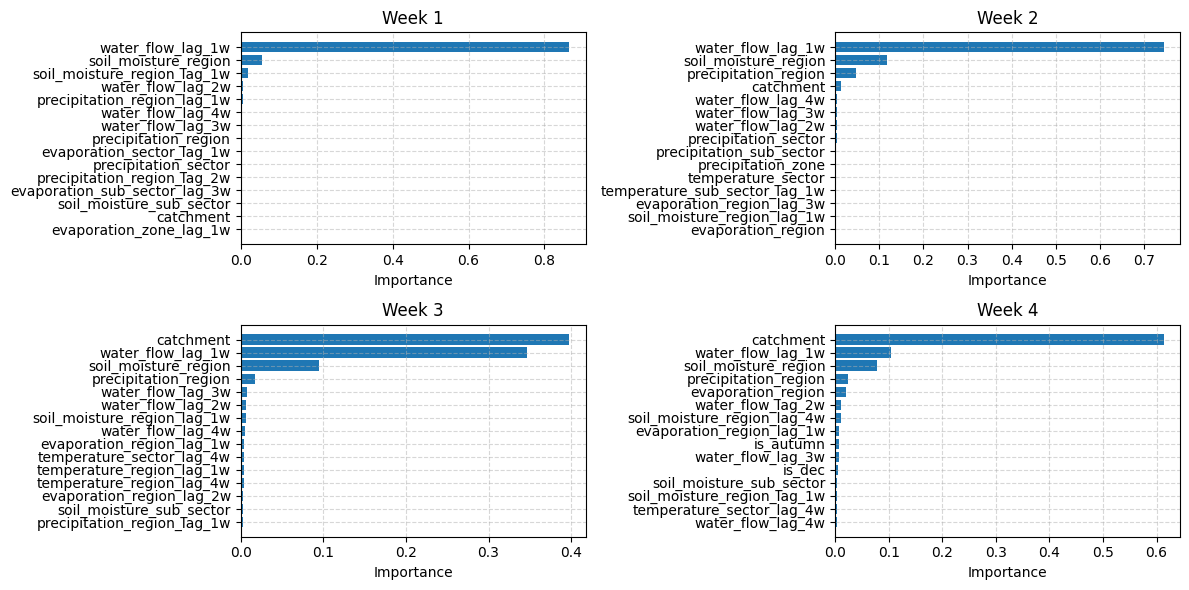

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_features_grid(importances_list, feature_names, top_n=10, titles=None):
    num_models = len(importances_list)
    if titles is None:
        titles = [f"Model {i+1}" for i in range(num_models)]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.flatten()

    for idx, (importances, ax) in enumerate(zip(importances_list, axes)):
        assert len(importances) == len(feature_names)
        importances = np.array(importances)
        sorted_idx = np.argsort(importances)[::-1]
        top_idx = sorted_idx[:top_n]
        top_features = np.array(feature_names)[top_idx]
        top_importances = importances[top_idx]

        ax.barh(range(top_n), top_importances[::-1], align='center')
        ax.set_yticks(range(top_n))
        ax.set_yticklabels(top_features[::-1])
        ax.set_xlabel("Importance")
        ax.set_title(titles[idx])
        ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()
importances_list = [model.feature_importances_ for model in final_models[:4]]
titles = ["Week 1", "Week 2", "Week 3", "Week 4"]

plot_top_features_grid(importances_list, inference_data.columns.tolist()[1:], top_n=15, titles=titles)

In [6]:
predictions = inference_data[['station_code']].copy()
y_pred_test_quantile = {}
y_pred_test = {}
X_test = inference_data.drop(columns=['station_code'])
for i in range(NUMBER_OF_WEEK):
    
    if FINAL_MODEL == "qrf":
        # reorder the columns
        X_test = X_test
        # X_test = X_test[final_models[0].feature_names_in_]
    predict_adjusted = create_predict_function(final_models, i, FINAL_MODEL)
    quantile_adjusted = create_quantile_function(final_models, i, FINAL_MODEL, ALPHA)
    
    y_pred_test[i] = predict_adjusted(X_test)
    y_pred_test_quantile[i] = quantile_adjusted(X_test)

for i in range(NUMBER_OF_WEEK):
    predictions[f"week_{i}_pred"] = y_pred_test[i]
    predictions[f"week_{i}_sup"] = y_pred_test_quantile[i][:,1]
    predictions[f"week_{i}_inf"] = y_pred_test_quantile[i][:,0]


/home/jfan/env/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/jfan/env/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/jfan/env/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/jfan/env/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/jfan/env/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/home/jfan/env/venv/lib/python3.10/site-packages/sklearn/bas

In [7]:
# By Jupyter file, 00 - Quantile_of_conformityscore, we discovered that the uncertainty for 2 unseen stations are around 10, 
# suppose that the distribution of non-conformity scores of the 2 hidden stations and the 2 unseen stations are the same, 
# then we can reasonably use the same quantile non-confomrity score to adjust (conformalize it)
quantile_score = 9.7 # 10

inf_cols = ['week_0_inf', 'week_1_inf', 'week_2_inf', 'week_3_inf']
sup_cols = ['week_0_sup', 'week_1_sup', 'week_2_sup', 'week_3_sup']

mask = predictions.station_code.isin([56688080, 56992400])

predictions.loc[mask, inf_cols] = (predictions.loc[mask, inf_cols] - quantile_score).clip(lower=0)
predictions.loc[mask, sup_cols] = predictions.loc[mask, sup_cols] + quantile_score

### 4. Saving of the predictions for mini-challenge
#### This file is only the source code for mini-challenge, not for the other predictions.

Actually, for the other predictions, we justed used the baseline model (quantile random forest provided in your source code, and we didn't improve it)

Saving of the predictions as a csv file

> The file must be named `predictions.csv`

In [8]:
# save the predictions to a csv file
predictions["ObsDate"] = X_test.index
predictions.to_csv(f"{EVAL_DIR}predictions.csv", index=False)
# Create a ZIP file containing predictions.csv
with zipfile.ZipFile(f"{EVAL_DIR}predictions.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(f"{EVAL_DIR}predictions.csv", "predictions.csv")
